This is a quick example of processing Dutch election tweets, and performing LDA.

In [4]:
# !pip install workcloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys


import pylab as plt
# All datasets need to be downloaded from nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from hlda.sampler import HierarchicalLDA
from ipywidgets import widgets
from IPython.core.display import HTML, display
from gensim import corpora, models

import string
import json
import random

ModuleNotFoundError: No module named 'wordcloud'

In [30]:
basedir = '../'
sys.path.append(basedir)

Load all tweets into a list.

In [10]:
def clean_tweet(tweet_text):
    # take out handles
    tweet_text = re.sub(r'\s\@[\w\:\_]+',r' handle',tweet_text)
    # take out urls
    tweet_text = re.sub(r'https:\/\/[\w\.\/]+',r' http',tweet_text)  

    return tweet_text


In [4]:
path="data/election"
file_list=os.listdir(path)
print(file_list)
all_json = []


for file in file_list:
    full_file = path+"/"+file
    with open(full_file) as f:
        all_json = json.load(f)
  

['full_tweet_non_english1202.json', 'full_tweet_non_english1303.json', 'full_tweet_non_english2202.json', 'full_tweet_non_english2303.json', 'full_tweet_non_english3303.json', 'full_tweet_non_english4303.json', 'full_tweet_non_english5303.json', 'full_tweet_non_english6303.json']


In [3]:
print(len(all_json))

21697


In [14]:
corpus = []
all_tweet = []
vocab = set()
for n,atweet in enumerate(all_json):
    filtered = []

    text = atweet["text"]
    
    # take off users and urls
    text = clean_tweet(text)
    all_tweet.append(text)
    tokens = word_tokenize(text)

    for w in tokens:

        w = w.lower()
        if len(w) < 3:              
            continue
        else:
            filtered.append(w)
    if (n%1000==0):
        print(n,end=" ")
        print(filtered)
    corpus.append(filtered)
    vocab.update(filtered)


0 ['een', 'duitse', 'minister', 'weigert', 'een', 'hoofddoek', 'dragen', 'daar', 'kan', 'mevr', 'handle', 'd66', 'die', 'zich', 'onder', 'werpt', 'aan…', 'http']
1000 ['handle', 'door', 'krapte', 'woningmarkt', 'een', 'fijn', 'huis', 'provincie', 'utrecht', 'soms', 'lastig', 'vinden', 'samen', 'met', 'handle', 'wil…']
2000 ['handle', 'nog', 'even', 'zelfs', 'pvda', 'passeert', "d'66", 'http']
3000 ['corsera', 'milan', 'martedì', 'cda', 'del', 'club', 'rossonero', 'breve', 'sarà', 'versato', 'altro', 'aumento', 'capitale', 'http']
4000 ['handle', 'handle', 'handle', 'handle', 'als', 'het', 'weer', 'geen', 'handle']
5000 ['handle', 'zijn', 'begonnen', 'kun', 'jij', 'niet', 'bij', 'zijn', 'volg', 'dan', 'onze', 'livestream', 'tweet', 'mee', 'met', 'groenlinkscongres', 'veranderin…']
6000 ['apechtold', 'd66', 'brengt', 'zich', 'eigen', 'naar', 'dode', 'toe']
7000 ['handle', 'wat', 'een', 'power', 'het', 'podium', 'van', 'het', 'congres', 'handle', 'met', 'speeches', 'van', 'lijsttrekkers',

Create an inverted index for the words to position in the sorted vocab

In [15]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

Total number of vocab. Also print the first 100 words in the sorted vocab.

In [16]:
print(len(vocab))
print(vocab[0:100])

22400
["''lunedì", "''minder", "''multiculturele", "'66", "'80", "'afgunst", "'ahre", "'alle", "'als", "'alt", "'baud…", "'bedreigingen", "'belastingparadijs", "'beste", "'besturen", "'bestuurlijke", "'bestuurskunde", "'betrokken", "'betrouwbare", "'blanke", "'boontje", "'busje", "'cenuur-", "'christenunie", "'contact", "'criminele", "'de", "'democraten", "'democratie", "'demoniseren", "'demonisering", "'denigrerende", "'denk", "'deugdivers", "'diego", "'diepe", "'discriminerend", "'door", "'doorgaan", "'een", "'ego", "'eindelijk", "'elite-schandknaap", "'en", "'er", "'erm…", "'ers", "'framen", "'gedemoniseerd", "'geef", "'gewoon", "'gezellig", "'gezonder", "'groenlinks", "'guilt", "'g…", "'hallo", "'handen", "'hardere", "'hattem", "'helemaal", "'het", "'hoeveel", "'hoop", "'ie", "'ik", "'integer'", "'investeer", "'jaloezie", "'je", "'jij", "'joodse", "'kameraad", "'keek", "'kijken", "'koningin", "'kwijtrake…", "'lafheid", "'laten", "'let", "'links", "'linkse", "'ll", "'luxe", "'macht"

## 2. Visualise the data

Make some pretty word cloud using the Python Word Cloud package: https://github.com/amueller/word_cloud

In [17]:
print(type(all_tweet))
alltext = ' '.join(all_tweet)
print(type(alltext))

<class 'list'>
<class 'str'>


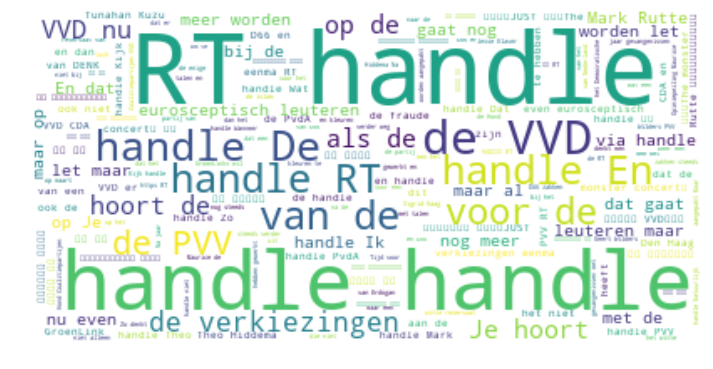

In [18]:

wordcloud = WordCloud(background_color='white').generate(alltext)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Run hLDA

In [19]:
print(len(vocab), len(corpus), len(corpus[0]), len(corpus[0])) 

22400 21697 18 18


Convert words in the corpus into indices

In [20]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [21]:
print(len(vocab), len(new_corpus))
print(corpus[0][0:10]) 
print(new_corpus[0][0:10])

22400 21697
['een', 'duitse', 'minister', 'weigert', 'een', 'hoofddoek', 'dragen', 'daar', 'kan', 'mevr']
[5562, 5395, 12251, 20887, 5562, 8749, 5299, 4410, 9999, 12105]


In [22]:
print(len(new_corpus))

21697


In [23]:
import random
select = random.sample(new_corpus,1000)

Create hierarchical LDA object and run the sampler.

In [27]:
n_samples = 50      # no of iterations for the sampler
alpha = 100          # smoothing over level distributions
gamma = 100          # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 10            # smoothing over topic-word distributions
num_levels = 2        # the number of levels in the tree
display_topics = 25   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

In [29]:
hlda = HierarchicalLDA(select, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling
......................... 25
topic 0 (level=0, total_words=9340, documents=1000): handle, http, van, het, dat, 
    topic 13 (level=1, total_words=115, documents=30): dat, grootste, daar, vandaag, arnhem, 
    topic 16 (level=1, total_words=39, documents=11): ouderen, แต่คา…, hij, nederlanders, nieuws, 
    topic 20 (level=1, total_words=105, documents=30): nieuwe, wilders, over, natuurlijk, sgpay, 
    topic 21 (level=1, total_words=114, documents=27): man, als, europese, actie, cda, 
    topic 26 (level=1, total_words=165, documents=43): doe, handle…, voeren, moesten, quits, 
    topic 28 (level=1, total_words=102, documents=29): het, gaan, lijstdouwer, tovert, mark, 
    topic 33 (level=1, total_words=40, documents=12): are, aanhoudende, wnl, kamer, gaat…, 
    topic 38 (level=1, total_words=218, documents=53): zien, maart, tegen, amsterdamse, willen, 
    topic 39 (level=1, total_words=137, documents=38): niet, rattenvanger, penthouse, bloemendaal, fvd, 
  